# Planify - Graph Neural Network

### Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
    <ul>
        <li><a href="#Imports">Imports</a></li>
        <li><a href="#func">Functions used</a></li>
    </ul>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#model">GNN Model</a></li>
    <ul>
        <li><a href="#dataLoader">Data Loader</a></li>
        <li><a href="#archi">Architecture</a></li>
        <li><a href="#train">Training</a></li> 
        <li><a href="#eval">Evaluation</a></li>
    </ul>
</ul>

<a id='intro'></a>
## Introduction

> This notebook getting garphs in the Networkx format from the `Creating Graphs` notebook. And its main goal is to make the GNN model.

In [2]:
# Used for vsCode only to show tqdm process
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

<a id='Imports'></a>
### Imports

In [3]:
# Only for kaggle
# !pip install torch_geometric -q

In [4]:
# Not included packages in kaggle

# Install torch_geometric
# !pip install /kaggle/input/torch-geometric/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl -q
# !pip install /kaggle/input/torch-geometric/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl -q

# # # library for getting distinct colores
# !pip install distinctipy -q

In [5]:
# for data wrangling
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import distinctipy
import random
from torch_geometric.utils import from_networkx

# to show advance in for loops
from tqdm import tqdm

# Using pytorch geometric
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset
import torch_geometric.transforms as T


# For the GNN model
import torch.nn.functional as F
from torch_geometric.nn import GATConv


# for my pc [linux]
# url = '/media/mo/DATA/Grad/Planify_Dataset/Graph/Planify_Graphs.pkl'

# for my pc [windows]
# url = "D:\Grad\Planify_Dataset\Graph\Planify_Graphs.pkl"
# url_real = "D:\Grad\Planify_Dataset\Graph\graphs\Graphs_real.pkl"
# url_boundary = r"D:\Grad\Planify_Dataset\Graph\graphs\boundaries.pkl"

url_living_to_all = "D:\Grad\Planify_Dataset\Planify_Graphs_Scaled\Graphs_living_to_all.pkl"
url_boundary = r"D:\Grad\Planify_Dataset\Planify_Graphs_Scaled\boundaries.pkl"
# for kaggle
# url_real = "/kaggle/input/planify-graphs-all-forms/Planify_Graphs_no_balacony_inner_centroid_used/Planify_Graphs/Graphs_real.pkl"
# url_real = "/kaggle/input/planify-graphs-all-forms/Planify_Graphs_Scaled/Planify_Graphs_Scaled/Graphs_real.pkl"
# url_living_to_all = "/kaggle/input/planify-graphs-all-forms/Planify_Graphs_Scaled/Planify_Graphs_Scaled/Graphs_living_to_all.pkl"
# url_boundary = "/kaggle/input/planify-graphs-all-forms/Planify_Graphs_Scaled/Planify_Graphs_Scaled/boundaries.pkl"



# url_living_to_all = "/kaggle/input/planify-graphs-all-forms/graphs/graphs/Graphs_living_to_all.pkl"
# url_boundary = "/kaggle/input/planify-graphs-all-forms/graphs/graphs/boundaries.pkl"

<a id='func'></a>
### Functions used

In [6]:
geoms_columns = ['inner', 'living', 'master', 'kitchen', 'bathroom', 'dining', 'child', 'study',
                   'second_room', 'guest', 'balcony', 'storage', 'wall-in',
                    'outer_wall', 'front', 'inner_wall', 'interior',
                   'front_door', 'outer_wall', 'entrance']

N = len(geoms_columns)
colors = (np.array(distinctipy.get_colors(N)) * 255).astype(np.uint8)
room_color = {room_name: colors[i] for i, room_name in enumerate(geoms_columns)}

In [7]:
def draw_graph_nodes(G, living_to_all=False):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['actualCentroid_x'], -G.nodes[node]['actualCentroid_y']) for node in G.nodes}
    
    scales = [G.nodes[node]['roomSize'] * 10000 for node in G] 
    color_map = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]
    edge_labels = nx.get_edge_attributes(G, 'distance')

    
    nx.draw_networkx_nodes(G, pos=pos, node_size=scales, node_color=color_map);
    nx.draw_networkx_edges(G, pos=pos, edge_color='b');
    nx.draw_networkx_labels(G, pos=pos, font_size=8);

    if living_to_all:
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

    
    # # Drawing the graph inside a good boundary.
    # x_coords  = [pos[node][0] for node in pos]
    # y_coords  = [pos[node][1] for node in pos]
    # threshold = max(scales) / 100
    
    # plt.xlim(min(x_coords) - threshold, max(x_coords) + threshold)
    plt.xlim(-10, 266)
    plt.ylim(-266, 10)
    

def draw_graph_boundary(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['centroid'][0], -G.nodes[node]['centroid'][1])  for node in G.nodes}
    
    door_color = '#90EE90'
    other_nodes_color = '#0A2A5B'
    color_map = [door_color if G.nodes[node]['type'] == 1 else other_nodes_color for node in G.nodes]
    
    # nx.draw(G, pos=pos, with_labels=True, node_color=color_map, font_color='w', font_size=12)
    nx.draw_networkx_nodes(G, pos=pos, node_size=150, node_color=color_map);
    nx.draw_networkx_edges(G, pos=pos)
    
    plt.xlim(-10, 266)
    plt.ylim(-266, 10)
    
    
# For statistics
def get_max_min_x_y(graphs):
    max_x = 0
    max_y = 0
    min_x = float('inf')
    min_y = float('inf')
    
    for G in tqdm(graphs, desc="Getting maximum x, y", total=len(graphs)):
        max_x_in_graph = G.x.T[1].max().item()
        max_y_in_graph = G.x.T[2].max().item()
        
        min_x_in_graph = G.x.T[1].min().item()
        min_y_in_graph = G.x.T[2].min().item()
        
        if max_x_in_graph > max_x:
            max_x = max_x_in_graph
        if max_y_in_graph > max_y:
            max_y = max_y_in_graph
            
        if min_x_in_graph < min_x:
            min_x = min_x_in_graph
        if min_y_in_graph < min_y:
            min_y = min_y_in_graph
            
    values = {'max_x': max_x, 'max_y': max_y, 'min_x': min_x, 'min_y': min_y}
    return values


def get_all_x_y(graphs):
    """Get all values of x and y from all graphs
        Input: list of graphs
        Output: x and y as pandas series
    """
    x = []
    y = []
    for i, G in tqdm(enumerate(graphs), desc="getting all Xs, Ys", total=len(graphs)):
        for i in range(len(G.x)):
            x.append(G.x[i][1].item())
            y.append(G.x[i][2].item())
            

    x = pd.Series(x)
    y = pd.Series(y)

    return x, y

def boxplot_centrValues(x, y):
    fig, ax = plt.subplots()

    # Plot the boxplots
    ax.boxplot([x, y])

    # Set the xtick labels
    ax.set_xticklabels(['x', 'y'])

    # Add axis labels and title
    ax.set_xlabel('Data')
    ax.set_ylabel('Value')
    ax.set_title('Boxplot of x and y in all graphs')

    # Show the plot
    plt.show()
    

def plot_histograms(x, y):
    x.hist(density=True, bins=100, alpha=0.6, label='x');
    y.hist(density=True, bins=100, alpha=0.3, label='y');
    plt.legend();
    plt.title('Distribution of x and y');

<a id='wrangling'></a>
## Data wrangling


In [8]:
with open(url_living_to_all, 'rb') as f:
    Graphs = pickle.load(f)
    
G = Graphs[1911]
print(G)

Graph with 8 nodes and 7 edges


> Considering boundaries

In [9]:
with open(url_boundary, 'rb') as f:
    boundaries = pickle.load(f)
    
b = boundaries[1911]
print(b)

Graph with 9 nodes and 9 edges


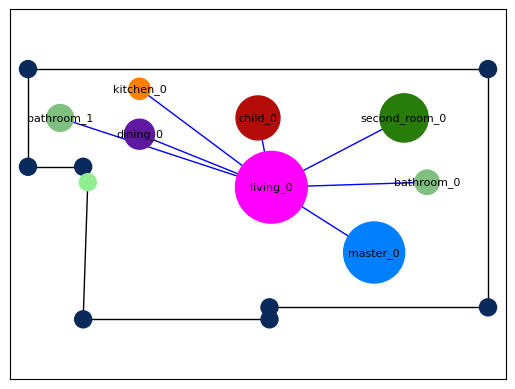

In [10]:
draw_graph_nodes(G)
draw_graph_boundary(b)

In [11]:
def convert_networkx_Graphs_to_pyTorchGraphs(G):
    """ Converting networkx graphs to pytorchGeo graphs
    """
    features = ['roomType_embd', 'actualCentroid_x', 'actualCentroid_y']
    G_new = from_networkx(G, group_node_attrs=features, group_edge_attrs=['distance'])
    return G_new

Graphs_pyTorch = list(map(convert_networkx_Graphs_to_pyTorchGraphs, Graphs))

In [12]:
def convert_networkx_Boundaries_to_pyTorchGraphs(b):
    """Converting networkx boundary graphs to PyTorchGeo graphs
    """
    b_new = from_networkx(b, group_node_attrs=['type', 'centroid'], group_edge_attrs=['distance'])
    return b_new

Boundaries_pyTorch = list(map(convert_networkx_Boundaries_to_pyTorchGraphs, boundaries))

> Statistics, To make normalization for x and y but to be able to get back to the real values

In [13]:
G_x, G_y = get_all_x_y(Graphs_pyTorch)
G_x.max(), G_y.max(), G_x.min(), G_y.min()

getting all Xs, Ys: 100%|██████████| 80787/80787 [00:07<00:00, 10516.84it/s]


(247.42583732057415, 247.84313725490196, 10.666666666666666, 8.577319587628866)

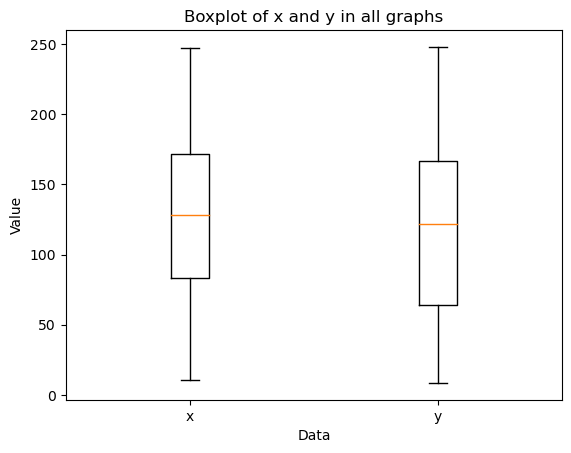

In [14]:
# making box plot for x and y for the graphs
boxplot_centrValues(G_x, G_y)

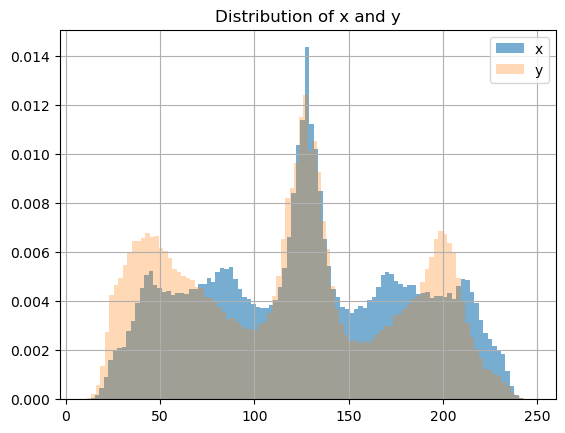

In [15]:
plot_histograms(G_x, G_y)

> And we saw the box plots so there is no outliers, and the distribution is normal
> 
> We will use z-score normalization, by taking a general mean and std for each of x and y

In [16]:
# print(f"Maximun x: {max_x}, Maximum y: {max_y}, Minimum x: {min_x}, Minimum y: {min_y}")
print("And we saw the box plots so there is no outliers, and the distribution is normal")
G_x_mean = G_x.mean()
G_y_mean = G_y.mean()
G_x_std  = G_x.std()
G_y_std  = G_y.std()
print("We will use z-score normalization")

And we saw the box plots so there is no outliers, and the distribution is normal
We will use z-score normalization


> There are many types of `rooms` but we will give them a defualt number = 1.
> So, also we will decrease the embedings to be between 0:6

In [17]:
print(f'Befor: G_1 embedings are: {Graphs_pyTorch[1].x}')
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    for j ,value in enumerate(G.x):
        type_ = int(value[0].item())
        
        if type_ in [1, 4, 5, 6, 7, 8]:
            G.x[j][0] = 1
        
        # making all labels from 0 to 6 only to help one_hotting
        elif type_ == 9:
            G.x[j][0] = 4
        elif type_ == 10:
            G.x[j][0] = 5
        elif type_ == 11:
            G.x[j][0] = 6


print(f'After: G_1 embedings are: {Graphs_pyTorch[1].x}')

Befor: G_1 embedings are: tensor([[  0.0000, 114.4449, 153.2065],
        [  1.0000, 207.2296, 196.9931],
        [  2.0000,  26.6358,  34.7746],
        [  3.0000, 222.7052, 140.5780],
        [  3.0000, 117.2607, 101.8013],
        [  7.0000, 163.5824, 101.4260],
        [  7.0000, 134.9086, 201.0376]], dtype=torch.float64)


100%|██████████| 80787/80787 [00:06<00:00, 11910.77it/s]

After: G_1 embedings are: tensor([[  0.0000, 114.4449, 153.2065],
        [  1.0000, 207.2296, 196.9931],
        [  2.0000,  26.6358,  34.7746],
        [  3.0000, 222.7052, 140.5780],
        [  3.0000, 117.2607, 101.8013],
        [  1.0000, 163.5824, 101.4260],
        [  1.0000, 134.9086, 201.0376]], dtype=torch.float64)


> Normalization for the centroids columns & hot encoding the type one for the graphs data.

In [18]:
# for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    
#     # Making tensor of means = [x_mean, y_mean] & tensor of stds = [x_std, y_std].
#     # We could make a tensor of ones = [rows, 2] then multiply it by the means, But we directly 
#     # multiply the means using the idea of "Broadcasting".
#     G.x[:, 1:] = (G.x[:, 1:] - torch.tensor([G_x_mean, G_y_mean])) / torch.tensor([G_x_std, G_y_std])
    
#     # One hot encoding for the first column [type of rooms]
#     first_column_encodings = F.one_hot(G.x[:, 0].long(), 7)
    
#     G.x = torch.cat([first_column_encodings, G.x[:, 1:]], axis=1)

In [19]:
# return_to_real = Graphs_pyTorch[1].x[:, [-2, -1]] * torch.tensor([G_x_std, G_y_std]) + torch.Tensor([G_x_mean, G_y_mean])
# print(f"Now, we could return back to real values: \n{return_to_real}")

> Normalizing the centroid of the boundaries

In [20]:
B_x, B_y = get_all_x_y(Boundaries_pyTorch)
B_x.max(), B_y.max(), B_x.min(), B_y.min()

getting all Xs, Ys: 100%|██████████| 80787/80787 [00:14<00:00, 5386.98it/s]


(340.0875912408759, 306.0, -57.6, -86.6771653543307)

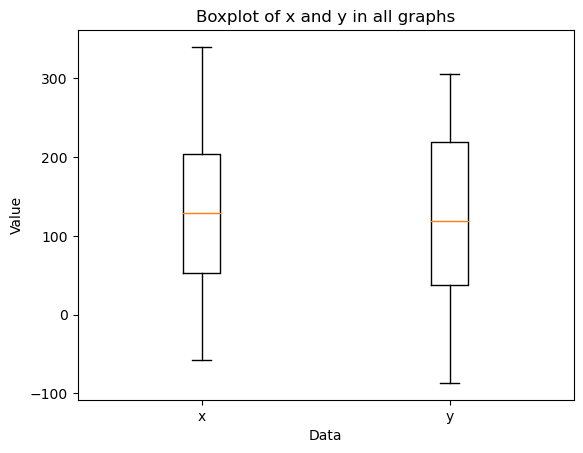

In [21]:
boxplot_centrValues(B_x, B_y)

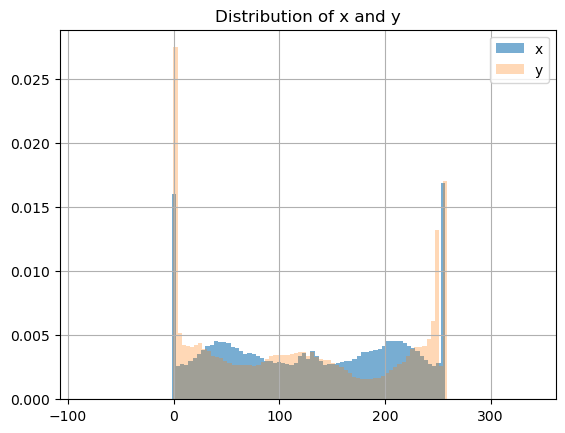

In [22]:
plot_histograms(B_x, B_y)

> most values in the edges of the images. As our images all of them is 256x256 and scaled.
>
> So most values on edges 0 and 256

In [23]:
# print(f"Maximun x: {max_x}, Maximum y: {max_y}, Minimum x: {min_x}, Minimum y: {min_y}")
print("And we saw the box plots so there is no outliers, and the distribution is normal")
B_x_mean = B_x.mean()
B_y_mean = B_y.mean()
B_x_std  = B_x.std()
B_y_std  = B_y.std()
print("We will use z-score normalization")

And we saw the box plots so there is no outliers, and the distribution is normal
We will use z-score normalization


In [24]:
# Boundaries_pyTorch[1].x

In [25]:
# for b in tqdm(Boundaries_pyTorch, total=len(Boundaries_pyTorch)):
    
#     # Making tensor of means = [x_mean, y_mean] & tensor of stds = [x_std, y_std].
#     # We could make a tensor of ones = [rows, 2] then multiply it by the means, But we directly 
#     # multiply the means using the idea of "Broadcasting".
#     b.x[:, 1:] = (b.x[:, 1:] - torch.tensor([B_x_mean, B_y_mean])) / torch.tensor([B_x_std, B_y_std])

In [26]:
# return_to_real = Boundaries_pyTorch[1].x[:, [-2, -1]] * torch.tensor([B_x_std, B_y_std]) + torch.Tensor([B_x_mean, B_y_mean])
# print(f"Now, we could return back to real values: \n{return_to_real}")

> If we need to creat graphs with padding by the maximum number of nodes.

In [27]:
# # but we need to do some padding to our graphs to be all of the same number of nodes.
# padded_graphs = []
# for G in Graphs_pyTorch:
#     x          = G.x
#     y          = G.roomType_embd
#     edge_index = G.edge_index
#     edge_attr  = G.edge_attr
    
#     nu_nodes = x.shape[0]

#     padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
#     padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
#     train_mask   = torch.ones(nu_nodes)
#     train_mask   = torch.nn.functional.pad(train_mask, pad=(0, 8 - nu_nodes), mode='constant', value=0).to(bool)

#     data = Data(x = padded_x, y = padded_y, edge_index= G.edge_index, edge_attr = G.edge_attr, train_mask=train_mask)

#     padded_graphs.append(data)

# padded_graphs[0]

<a id='model'></a>
## GNN Model

<a id='dataLoader'></a>
### Data Loader

In [28]:
class Planify_Dataset(Dataset):
    def __init__(self, Graphs, Boundaries):
        self.Graphs = Graphs
        self.Boundaries = Boundaries
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def __len__(self):
        return len(self.Graphs)
    
    def Augment_graph(self, graph, rand_value):
        graph.x[:, [-2, -1]] += rand_value
        graph.rec_h += rand_value
        graph.rec_w += rand_value
        
        return graph
    
    def Augment_boundary(self, boundary, rand_value):
        boundary.x[:, [-2, -1]] += rand_value
        return boundary
    
    def __getitem__(self, index):
        G = self.Graphs[index].clone()
        B = self.Boundaries[index].clone()
        
        G.x = G.x.to(torch.float32)
        B.x = B.x.to(G.x.dtype)
        B.edge_index = B.edge_index.to(G.edge_index.dtype)
        B.edge_attr = B.edge_attr.to(G.edge_attr.dtype)
        
        
        # Data Auqmatation by adding noise values.
        rand_value = torch.rand(1)
        G = self.Augment_graph(G, rand_value)
        B = self.Augment_boundary(B, rand_value)
        
        # Normalization for the G graph
        G.x[:, 1:] = (G.x[:, 1:] - torch.tensor([G_x_mean, G_y_mean])) / torch.tensor([G_x_std, G_y_std])
        # One hot encoding for the first column [type of rooms]
        first_column_encodings = F.one_hot(G.x[:, 0].long(), 7)
        G.x = torch.cat([first_column_encodings, G.x[:, 1:]], axis=1)
        # Normalization for the Boundary graph
        B.x[:, 1:] = (B.x[:, 1:] - torch.tensor([B_x_mean, B_y_mean])) / torch.tensor([B_x_std, B_y_std])
        
        
        # shuffling nodes inside the same graph
        permutation = torch.randperm(G.num_nodes)
        
        G.x = G.x[permutation]
        G.edge_index = permutation[G.edge_index]
        G.rec_w = G.rec_w[permutation]
        G.rec_h = G.rec_h[permutation]
        G.edge_attr = G.edge_attr[permutation]
        
        # padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
        # padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
        graphs = {
            'G': G.to(self.device),
            'B': B.to(self.device)
        }
        
        return graphs

In [29]:
edge = int(len(Graphs_pyTorch) * 0.8)

In [30]:
batch_size = 32
# edge = 10000
train_dataset = Planify_Dataset(Graphs_pyTorch[:edge], Boundaries_pyTorch[:edge])
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# edge = -1000
val_dataset = Planify_Dataset(Graphs_pyTorch[edge:-10], Boundaries_pyTorch[edge:-10])
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = Planify_Dataset(Graphs_pyTorch[-10:], Boundaries_pyTorch[-10:])
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [31]:
# Saving model function
import os

# checkpoint_dir = '/kaggle/working/checkpoints'
# checkpoint_dir = '/media/mo/DATA/Grad/Planify_Dataset/Graph/checkpoints'
checkpoint_dir = "./checkpoints"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    

def save_checkpoint(model, optimizer, epoch):
    checkpoint_path = os.path.join(checkpoint_dir, f'Best_model_V3.pt')
    # Saving model each 15 epochs
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, checkpoint_path)
    
    print('Model saved :)')

<a id='archi'></a>
### Architecture

In [32]:
# class GATNet(torch.nn.Module):
#     def __init__(self, num_graph_node_features, num_boundary_node_features):
#         super(GATNet, self).__init__()
        
#         self.graph_conv1 = GATConv(num_graph_node_features, 32, heads=8)
#         self.graph_conv2 = GATConv(32*8, 64, heads=8)
        
#         self.skip1 = nn.Linear(9, 64*8)
        
#         self.graph_conv3 = GATConv(64*8, 128, heads=8)
#         self.graph_conv4 = GATConv(128*8, 128, heads=8)
        
#         self.skip2 = nn.Linear(64*8, 128*8)

#         shape_of_graphs_befor_concatination = 128*8
        
#         ############################### Boundary ################################
        
#         self.boundary_conv1 = GATConv(num_boundary_node_features, 32, heads=8)
#         self.boundary_conv2 = GATConv(32*8, 64, heads=8)
        
#         self.boundary_skip = nn.Linear(num_boundary_node_features, 64*8)
        
#         shape_of_boundary_befor_concatination = 64*8
        
#         inputs_concatination = shape_of_graphs_befor_concatination + shape_of_boundary_befor_concatination
#         self.Concatination1  = GATConv(inputs_concatination, 128, heads=8)
        
#         self.width_skip1 = nn.Linear(128*8, 64)
#         self.height_skip1 = nn.Linear(128*8, 64)
#         self.width_skip2 = nn.Linear(64, 8)
#         self.height_skip2 = nn.Linear(64, 8)
        
#         self.width_layer1  = nn.Linear(128*8, 128)
#         self.height_layer1 = nn.Linear(128*8, 128)
        
#         self.width_layer2  = nn.Linear(128, 64)
#         self.height_layer2 = nn.Linear(128, 64)
        
#         self.width_layer3  = nn.Linear(64, 32)
#         self.height_layer3 = nn.Linear(64, 32)
        
#         self.width_layer4 = nn.Linear(32, 8)
#         self.height_layer4 = nn.Linear(32, 8)
        
#         self.width_output  = nn.Linear(8, 1)
#         self.height_output = nn.Linear(8, 1)
        
#         self.boundary_pool = torch.nn.AdaptiveAvgPool1d(1)
#         self.dropout = torch.nn.Dropout(0.25)
        
#     def forward(self, graph, boundary):
#         x_graph, g_edge_index, g_edge_attr, g_batch = graph.x, graph.edge_index, graph.edge_attr, graph.batch
#         x_boundary, b_edge_indexy, b_edge_attr, b_batch = boundary.x, boundary.edge_index, boundary.edge_attr, boundary.batch
        
#         NUM_OF_NODES = x_graph.shape[0]
#         # During testing, as we input only one graph.
#         if g_batch == None:
#             g_batch = torch.zeros(x_graph.shape[0], dtype=torch.long)
#         if b_batch == None:
#             b_batch = torch.zeros(x_boundary.shape[0], dtype=torch.long)
        
        
#         x_graph_res = self.skip1(x_graph)
#         x_boundary_res = self.boundary_skip(x_boundary)
        
#         # Passing the graph throught a message passing to embed its features
#         x_graph = F.leaky_relu(self.graph_conv1(x_graph, g_edge_index))
#         x_graph = self.dropout(x_graph)
#         x_graph = self.graph_conv2(x_graph, g_edge_index)
        
#         x_graph = F.leaky_relu(x_graph + x_graph_res)
#         x_graph_res = self.skip2(x_graph)
        
#         x_graph = self.dropout(x_graph)
#         x_graph = F.leaky_relu(self.graph_conv3(x_graph, g_edge_index))
#         x_graph = self.graph_conv4(x_graph, g_edge_index)
        
#         x_graph = F.leaky_relu(x_graph + x_graph_res)
#         x_graph = self.dropout(x_graph)
        
#         # Passing the boundary throught a message passing to embed its features
#         x_boundary = F.leaky_relu(self.boundary_conv1(x_boundary, b_edge_indexy))
#         x_boundary = self.dropout(x_boundary)
#         x_boundary = self.boundary_conv2(x_boundary, b_edge_indexy)
        
#         x_boundary = F.leaky_relu(x_boundary + x_boundary_res)
#         x_boundary = self.dropout(x_boundary)
        
#         # Pooling the bounadry to 1D vector by getting max value in each feature for all nodes.
#         x_boundary_pooled = F.max_pool1d(x_boundary.transpose(0, 1), kernel_size=x_boundary.shape[0]).view(1, -1)
        
#         # Concatinating the graph & the boundary
#         x = torch.cat([x_graph, x_boundary_pooled.repeat(NUM_OF_NODES, 1)], dim=1)
#         x = F.leaky_relu(self.Concatination1(x, g_edge_index))
#         x = self.dropout(x)
        
        
#         width_res = self.width_skip1(x)
        
#         width = F.leaky_relu(self.width_layer1(x))
#         width = self.dropout(width)
#         width = self.width_layer2(width)
#         width = F.leaky_relu(width + width_res)
        
#         width_res = self.width_skip2(width)
#         width = self.dropout(width)
        
#         width = F.leaky_relu(self.width_layer3(width))
#         width = self.dropout(width)
#         width = self.width_layer4(width)
#         width = F.leaky_relu(width + width_res)
#         width = self.dropout(width)
        
#         width = self.width_output(width)
        
        
#         ### Height ####
#         height_res = self.height_skip1(x)
        
#         height = F.leaky_relu(self.height_layer1(x))
#         height = self.dropout(height)
#         height = self.height_layer2(height)
#         height = F.leaky_relu(height + height_res)
        
#         height_res = self.height_skip2(height)
#         height = self.dropout(height)
        
#         height = F.leaky_relu(self.height_layer3(height))
#         height = self.dropout(height)
#         height = self.height_layer4(height)
#         height = F.leaky_relu(height + height_res)
#         height = self.dropout(height)
        
#         height = self.height_output(height)
        
#         return width.squeeze(), height.squeeze()

# # num_graph_node_features = Graphs_pyTorch[0].x.shape[1]
# # num_boundary_node_features = Boundaries_pyTorch[0].x.shape[1]

# num_graph_node_features = 9
# num_boundary_node_features = 3
# model = GATNet(num_graph_node_features, num_boundary_node_features)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# # to monitor the loss & accuracy.
# errors = []
# acc = []

# model

In [33]:
from torch_geometric.nn import GlobalAttention
from torch_geometric.nn.dense import DenseGCNConv

class GATNet(torch.nn.Module):
    def __init__(self, num_graph_node_features, num_boundary_node_features):
        super(GATNet, self).__init__()
        
        self.graph_conv1 = GATConv(num_graph_node_features, 32, heads=8, dropout=0.25)
        self.graph_conv2 = GATConv(32*8, 64, heads=8, dropout=0.25)
        
        self.skip1 = nn.Linear(9, 64*8)
        
        self.graph_conv3 = GATConv(64*8, 128, heads=8, dropout=0.25)
        self.graph_conv4 = GATConv(128*8, 128, heads=16, dropout=0.25)
        
        self.skip2 = nn.Linear(64*8, 128*16)
        
#         self.graph_conv5 = GATConv(128*16, 256, heads=8, dropout=0.25)
#         self.graph_conv6 = GATConv(256*8, 256, heads=16, dropout=0.25)
        
#         self.skip3 = nn.Linear(128*16, 256*16)

        shape_of_graphs_befor_concatination = 128*16
    
        ############################### Boundary ################################
        
        self.boundary_conv1 = GATConv(num_boundary_node_features, 32, heads=8, dropout=0.25)
        self.boundary_conv2 = GATConv(32*8, 64, heads=8, dropout=0.25)
        
        self.boundary_Skip = nn.Linear(num_boundary_node_features, 64*8)
        
        shape_of_boundary_befor_concatination = 64*8
        
        inputs_concatination = shape_of_graphs_befor_concatination + shape_of_boundary_befor_concatination
        self.Concatination1  = GATConv(inputs_concatination, 128, heads=8)
        
        self.width_layer1  = nn.Linear(128*8, 128)
        self.height_layer1 = nn.Linear(128*8, 128)
        
        self.width_output  = nn.Linear(128, 1)
        self.height_output = nn.Linear(128, 1)
        
        self.dropout = torch.nn.Dropout(0.25)
        
    def forward(self, graph, boundary):
        x_graph, g_edge_index, g_edge_attr = graph.x, graph.edge_index, graph.edge_attr
        x_boundary, b_edge_indexy, b_edge_attr = boundary.x, boundary.edge_index, boundary.edge_attr
        
        NUM_OF_NODES = x_graph.shape[0]

        x_graph_res = self.skip1(x_graph)
        x_boundary_res = self.boundary_Skip(x_boundary)
        
        # Passing the graph throught a message passing to embed its features
        x_graph = F.leaky_relu(self.graph_conv1(x_graph, g_edge_index))
        x_graph = self.graph_conv2(x_graph, g_edge_index)
        x_graph = F.leaky_relu(x_graph + x_graph_res)
        
        x_graph_res = self.skip2(x_graph)
        
        x_graph = F.leaky_relu(self.graph_conv3(x_graph, g_edge_index))
        x_graph = self.graph_conv4(x_graph, g_edge_index)
        
        x_graph = F.leaky_relu(x_graph + x_graph_res)
#         x_graph_res = self.skip3(x_graph)
        
#         x_graph = F.leaky_relu(self.graph_conv5(x_graph, g_edge_index))
#         x_graph = self.graph_conv6(x_graph, g_edge_index)
        
#         x_graph = F.leaky_relu(x_graph + x_graph_res)
        
        # Passing the boundary throught a message passing to embed its features
        x_boundary = F.leaky_relu(self.boundary_conv1(x_boundary, b_edge_indexy))
        x_boundary = self.boundary_conv2(x_boundary, b_edge_indexy)
        
        x_boundary = F.leaky_relu(x_boundary + x_boundary_res)
        
        # Pooling the bounadry to 1D vector by getting max value in each feature for all nodes.
        x_boundary_pooled = F.max_pool1d(x_boundary.transpose(0, 1), kernel_size=x_boundary.shape[0]).view(1, -1)
        
        # Concatinating the graph & the boundary
        x = torch.cat([x_graph, x_boundary_pooled.repeat(NUM_OF_NODES, 1)], dim=1)
        x = F.leaky_relu(self.Concatination1(x, g_edge_index))
        x = self.dropout(x)

        
        width = F.leaky_relu(self.width_layer1(x))
        width = self.dropout(width)
        
        width = self.width_output(width)
        
        height = F.leaky_relu(self.height_layer1(x))
        height = self.dropout(height)
        
        height = self.height_output(height)
        
        return width.squeeze(), height.squeeze()

num_graph_node_features = Graphs_pyTorch[0].x.shape[1]
num_boundary_node_features = Boundaries_pyTorch[0].x.shape[1]

num_graph_node_features, num_boundary_node_features = 9, 3
model = GATNet(num_graph_node_features, num_boundary_node_features)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# to monitor the loss & accuracy.
errors = []
acc = []

model

GATNet(
  (graph_conv1): GATConv(9, 32, heads=8)
  (graph_conv2): GATConv(256, 64, heads=8)
  (skip1): Linear(in_features=9, out_features=512, bias=True)
  (graph_conv3): GATConv(512, 128, heads=8)
  (graph_conv4): GATConv(1024, 128, heads=16)
  (skip2): Linear(in_features=512, out_features=2048, bias=True)
  (boundary_conv1): GATConv(3, 32, heads=8)
  (boundary_conv2): GATConv(256, 64, heads=8)
  (boundary_Skip): Linear(in_features=3, out_features=512, bias=True)
  (Concatination1): GATConv(2560, 128, heads=8)
  (width_layer1): Linear(in_features=1024, out_features=128, bias=True)
  (height_layer1): Linear(in_features=1024, out_features=128, bias=True)
  (width_output): Linear(in_features=128, out_features=1, bias=True)
  (height_output): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [34]:
# class GATNet(torch.nn.Module):
#     def __init__(self, num_graph_node_features, num_boundary_node_features):
#         super(GATNet, self).__init__()
        
#         self.graph_conv1 = GATConv(num_graph_node_features, 32, heads=4)
        
#         input_of_conv2   = num_graph_node_features + 32*4
#         self.graph_conv2 = GATConv(input_of_conv2, 32, heads=8)
        
#         input_of_conv3   = num_graph_node_features + 32*8
#         self.graph_conv3 = GATConv(input_of_conv3, 64, heads=8)
        
#         input_of_conv4   = num_graph_node_features + 64*8
#         self.graph_conv4 = GATConv(input_of_conv4, 128, heads=8)
#         # self.graph_conv5 = GATConv(128*8, 128, heads=8)
#         # self.graph_conv6 = GATConv(128*8, 128, heads=16)
#         # self.graph_conv7 = GATConv(128*16, 256, heads=16)
#         # self.graph_conv8 = GATConv(256*16, 256, heads=16)
#         shape_of_graphs_befor_concatination = num_graph_node_features + 128*8
        
#         self.boundary_conv1 = GATConv(num_boundary_node_features, 32, heads=4)
#         input_of_boundary_conv2 = 32*4 + num_boundary_node_features
#         self.boundary_conv2 = GATConv(input_of_boundary_conv2, 32, heads=8)
#         # self.boundary_conv3 = GATConv(32*8, 64, heads=8)
#         # self.boundary_conv4 = GATConv(64*8, 128, heads=8)
#         # self.boundary_conv5 = GATConv(128*8, 128, heads=8)
#         shape_of_boundary_befor_concatination = num_boundary_node_features + 32 * 8
        
#         # Output of graph_conv8 + output of boundary_conv5 + 2 step connection from real nodes and boundary nodes
#         inputs_concatination = shape_of_graphs_befor_concatination + shape_of_boundary_befor_concatination
#         self.Concatination1  = GATConv(inputs_concatination, 128, heads=8)
#         # self.Concatination2  = GATConv(128*8, 64, heads=8)
#         # self.Concatination3  = GATConv(64*8, 64, heads=8)
#         # self.Concatination4  = GATConv(64*8, 32, heads=8)
#         # self.Concatination5  = GATConv(32*8, 32*4)
        
#         # self.lin1 = nn.Linear(inputs_concatination, 256)
#         # self.lin2 = nn.Linear(256, 32)
        
#         self.width_layer1  = nn.Linear(128*8, 128)
#         self.height_layer1 = nn.Linear(128*8, 128)
        
#         # self.width_layer2  = nn.Linear(256, 128)
#         # self.height_layer2 = nn.Linear(256, 128)
        
#         # self.width_layer3  = nn.Linear(128, 32)
#         # self.height_layer3 = nn.Linear(128, 32)
        
#         # self.width_layer4  = nn.Linear(32, 8)
#         # self.height_layer4 = nn.Linear(32, 8)
        
#         self.width_output  = nn.Linear(128, 1)
#         self.height_output = nn.Linear(128, 1)
        
        
#         self.boundary_pool = torch.nn.AdaptiveAvgPool1d(1)
#         self.dropout = torch.nn.Dropout(0.2)
        
#     def forward(self, graph, boundary):
#         x_graph, g_edge_index, g_edge_attr, g_batch = graph.x, graph.edge_index, graph.edge_attr, graph.batch
#         x_boundary, b_edge_indexy, b_edge_attr, b_batch = boundary.x, boundary.edge_index, boundary.edge_attr, boundary.batch
        
#         NUM_OF_NODES = x_graph.shape[0]
#         # During testing, as we input only one graph.
#         if g_batch == None:
#             g_batch = torch.zeros(x_graph.shape[0], dtype=torch.long)
#         if b_batch == None:
#             b_batch = torch.zeros(x_boundary.shape[0], dtype=torch.long)
        
        
#         x_graph_res = x_graph
#         x_boundary_res = x_boundary
        
#         # Passing the graph throught a message passing to embed its features
#         x_graph = F.leaky_relu(self.graph_conv1(x_graph, g_edge_index))
#         x_graph = self.dropout(x_graph) # Concatinate with step connection from real values.
#         x_graph = torch.cat([x_graph, x_graph_res], dim=1)
        
        
#         x_graph = F.leaky_relu(self.graph_conv2(x_graph, g_edge_index))
#         x_graph = self.dropout(x_graph)
#         x_graph = torch.cat([x_graph, x_graph_res], dim=1)
        
#         x_graph = F.leaky_relu(self.graph_conv3(x_graph, g_edge_index))
#         x_graph = self.dropout(x_graph) 
#         x_graph = torch.cat([x_graph, x_graph_res], dim=1)
        
#         x_graph = F.leaky_relu(self.graph_conv4(x_graph, g_edge_index))
#         x_graph = self.dropout(x_graph) 
#         x_graph = torch.cat([x_graph, x_graph_res], dim=1)
        
#         # x_graph = F.leaky_relu(self.graph_conv5(x_graph, g_edge_index))
#         # x_graph = F.leaky_relu(self.graph_conv6(x_graph, g_edge_index))
#         # x_graph = self.dropout(x_graph)
#         # x_graph = F.leaky_relu(self.graph_conv7(x_graph, g_edge_index))
#         # x_graph = F.leaky_relu(self.graph_conv8(x_graph, g_edge_index))
#         # x_graph = self.dropout(x_graph)
        
        
#         # Passing the boundary throught a message passing to embed its features
#         x_boundary = F.leaky_relu(self.boundary_conv1(x_boundary, b_edge_indexy))
#         x_boundary = self.dropout(x_boundary)
#         x_boundary = torch.cat([x_boundary, x_boundary_res], dim=1)
        
#         x_boundary = F.leaky_relu(self.boundary_conv2(x_boundary, b_edge_indexy))
#         x_boundary = self.dropout(x_boundary)
#         x_boundary = torch.cat([x_boundary, x_boundary_res], dim=1)
        
#         # x_boundary = F.leaky_relu(self.boundary_conv3(x_boundary, b_edge_indexy))
#         # x_boundary = self.dropout(x_boundary)
#         # x_boundary = F.leaky_relu(self.boundary_conv4(x_boundary, b_edge_indexy))
#         # x_boundary = F.leaky_relu(self.boundary_conv5(x_boundary, b_edge_indexy))
#         # x_boundary = self.dropout(x_boundary)

#         # Pooling the bounadry to 1D vector by getting max value in each feature for all nodes.
#         x_boundary_pooled = F.max_pool1d(x_boundary.transpose(0, 1), kernel_size=x_boundary.shape[0]).view(1, -1)
        
#         # Concatinating the graph & the boundary
#         x = torch.cat([x_graph, x_boundary_pooled.repeat(NUM_OF_NODES, 1)], dim=1)
#         x = F.leaky_relu(self.Concatination1(x, g_edge_index))
#         x = self.dropout(x)
#         # x = F.leaky_relu(self.Concatination2(x, g_edge_index))
#         # x = self.dropout(x)
#         # x = F.leaky_relu(self.Concatination3(x, g_edge_index))
#         # x = self.dropout(x)
#         # x = F.leaky_relu(self.Concatination4(x, g_edge_index))
#         # x = self.dropout(x)
#         # x = F.leaky_relu(self.Concatination5(x, g_edge_index))
#         # x = self.dropout(x)
        
#         # x = F.leaky_relu(self.lin1(x))
#         # x = self.dropout(x)
#         # x = F.leaky_relu(self.lin2(x))
#         # x = self.dropout(x)
        
        
#         width = F.leaky_relu(self.width_layer1(x))
#         # width = F.leaky_relu(self.width_layer2(width))
#         # width = F.leaky_relu(self.width_layer3(width))
#         # width = F.leaky_relu(self.width_layer4(width))
#         width = self.dropout(width)
#         width = self.width_output(width)
        
#         height = F.leaky_relu(self.height_layer1(x))
#         # height = F.leaky_relu(self.height_layer2(height))
#         # height = F.leaky_relu(self.height_layer3(height))
#         # height = F.leaky_relu(self.height_layer4(height))
#         height = self.dropout(height)
#         height = self.height_output(height)
        
#         return width.squeeze(), height.squeeze()

# num_graph_node_features = 9
# num_boundary_node_features = 3

# model = GATNet(num_graph_node_features, num_boundary_node_features)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# model

In [35]:
def train(model, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()
        # Forward pass
        graph, boundary = data['G'], data['B']
        
        width, height    = model(graph, boundary)
        
        # targets = torch.cat((graph.rec_w.unsqueeze(1), graph.rec_h.unsqueeze(1)), dim=1)
        # print(logits[0].shape, logits[1].shape, targets.shape)
        
        width_loss = criterion(width, graph.rec_w)
        height_loss = criterion(height, graph.rec_h)

        loss = width_loss + height_loss

        # Backward pass
        loss.backward()
        
        # Updating parameters
        optimizer.step()

        # Monitoring
        running_loss += loss.item()
        
    return running_loss / len(train_loader)


def evaluate(model, criterion, val_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            graph, boundary = data['G'], data['B']
            width, height    = model(graph, boundary)
            width_loss = criterion(width, graph.rec_w)
            height_loss = criterion(height, graph.rec_h)

            loss = width_loss + height_loss
            running_loss += loss.item()
            
    return running_loss / len(val_loader)

In [36]:
from copy import deepcopy

# Hyperparameters
learning_rate = 3e-4
num_epochs = 250
patience = 10 # Number of epochs to wait if validation loss doesn't improve
best_val_loss = float('inf')

counter = 0

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-3)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.950)


In [37]:
# Notice
train_losses = []
val_losses = []

In [38]:
# checkpoint_path = "/kaggle/input/best-model-v2/Best_model_V2.pt"
# checkpoint = torch.load(checkpoint_path)


# model.load_state_dict(checkpoint['model_state_dict'])
# # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

<a id='train'></a>
### Training


In [39]:
num_epochs = 5

In [47]:
for epoch in range(num_epochs):
    # Training loop
    train_loss = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss)
    
    # Evaluation loop
    print("Validating ...")
    val_loss = evaluate(model, criterion, val_loader)
    val_losses.append(val_loss)
    
    # Printing and monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        save_checkpoint(best_model, optimizer, epoch)
        counter = 0
        
    else:
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
            break
        if counter in range(2, 20, 2):
            scheduler.step()
            print(f"Learning rate decreased!, now is {optimizer.state_dict()['param_groups'][0]['lr']}")

100%|██████████| 2020/2020 [02:54<00:00, 11.55it/s]


Validating ...
Epoch [1/5], Train Loss: 520.3002, Validation Loss: 656.2203
Learning rate decreased!, now is 0.000244351875


100%|██████████| 2020/2020 [02:54<00:00, 11.58it/s]


Validating ...
Epoch [2/5], Train Loss: 512.7142, Validation Loss: 706.1602


100%|██████████| 2020/2020 [38:26<00:00,  1.14s/it]    


Validating ...
Epoch [3/5], Train Loss: 505.2582, Validation Loss: 637.0532
Learning rate decreased!, now is 0.00023213428124999998


100%|██████████| 2020/2020 [02:40<00:00, 12.60it/s]


Validating ...
Epoch [4/5], Train Loss: 497.1305, Validation Loss: 634.2088


100%|██████████| 2020/2020 [02:37<00:00, 12.86it/s]


Validating ...
Epoch [5/5], Train Loss: 492.7916, Validation Loss: 533.6995
Model saved :)


In [41]:
for epoch in range(num_epochs):
    # Training loop
    train_loss = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss)
    
    # Evaluation loop
    print("Validating ...")
    val_loss = evaluate(model, criterion, val_loader)
    val_losses.append(val_loss)
    
    # Printing and monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        save_checkpoint(best_model, optimizer, epoch)
        counter = 0
        
    else:
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
            break
        if counter in range(2, 20, 2):
            scheduler.step()
            print(f"Learning rate decreased!, now is {optimizer.state_dict()['param_groups'][0]['lr']}")

100%|██████████| 2020/2020 [02:58<00:00, 11.30it/s]


Validating ...
Epoch [1/5], Train Loss: 676.3460, Validation Loss: 708.5731


100%|██████████| 2020/2020 [03:00<00:00, 11.18it/s]


Validating ...
Epoch [2/5], Train Loss: 649.3273, Validation Loss: 598.0869
Model saved :)


100%|██████████| 2020/2020 [02:58<00:00, 11.33it/s]


Validating ...
Epoch [3/5], Train Loss: 628.8904, Validation Loss: 644.1204


100%|██████████| 2020/2020 [02:58<00:00, 11.30it/s]


Validating ...
Epoch [4/5], Train Loss: 608.0020, Validation Loss: 715.0457
Learning rate decreased!, now is 0.000285


100%|██████████| 2020/2020 [03:33<00:00,  9.45it/s]


Validating ...
Epoch [5/5], Train Loss: 591.3221, Validation Loss: 663.4499


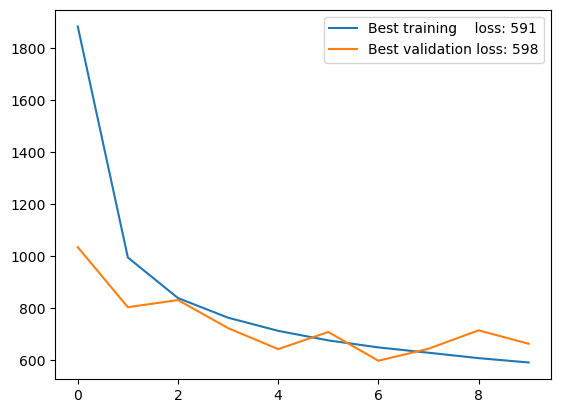

In [44]:
plt.plot(train_losses, label=f'Best training    loss: {min(train_losses):.0f}');
plt.plot(val_losses, label=f'Best validation loss: {min(val_losses):.0f}');
plt.legend();

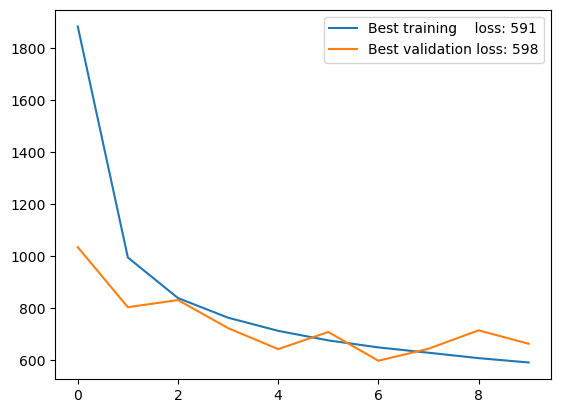

In [45]:
plt.plot(train_losses, label=f'Best training    loss: {min(train_losses):.0f}');
plt.plot(val_losses, label=f'Best validation loss: {min(val_losses):.0f}');
plt.legend();